<a href="https://colab.research.google.com/github/aharriechen/hello-world/blob/master/ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prices Prediction in Machine Learning Techniques

ID：13059276

https://github.com/aharriechen/hello-world/blob/master/ass2.ipynb[Assignment links]

https://github.com/aharriechen/hello-world/blob/master/Arima.ipynb[
Additional links]

**Introduction**

Machine learning plays a huge role in financial institutions because they can predict time series data with high precision to obtain money. For example, predict the trend of stock prices. In fact, predicting how the stock market will change is difficult. This forecasting behavior can be influenced by many factors —— including financial fundamentals or psychological factors. All these factors combine to make stock prices volatile and difficult to predict accurately. So engineers continue to work on the model, hoping to make it more accurate.

In this paper, we will study the historical data of stock prices of listed companies. We will combine machine learning algorithms to predict the company's future stock price.

**Methodology**

**1. Identify the problem.**

Stock analysis is judged from two aspects -- fundamentals and technical aspects.

Fundamental analysis represents a prediction of the company's future profitability based on its current financial position.

Technical analysis analyze charts to determine the future trend of stocks.

The emphasis in this paper will be on the technical analysis section. 

**2. Selected data**

The data I selected was OMX Stockholm Consumer Services GI (SX5000GI). The source is free data from Quandl.

The time is from January 3, 2016 to September 20, 2019.

source: [SX5000GI](https://www.quandl.com/data/NASDAQOMX/SX5000GI-OMX-Stockholm-Consumer-Services-GI-SX5000GI/)

**Step:**

Because the files the program needs to call are too large, I store it on geogle drive.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'17CQjr0eD3jSFhOueXAg9eoYQKkTCcTQ8'}) 

downloaded.GetContentFile('train.csv')  

#3. Read file as panda dataframe
import pandas as pd
xyz = pd.read_csv('train.csv') 

W0927 17:08:15.041661 140706813450112 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth


The **Keras** program is installed. It is a deep learning library based on Theano and TensorFlow, as well as a high-level neural network API written in Python. Keras's development can support fast experiments and  quickly turn my ideas into results.

In [0]:
pip install keras

**GraphViz** is used for neural network visualization.

In [0]:
pip install graphviz

In [0]:
pip install pydotplus

In [0]:

%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from matplotlib import style
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from IPython.display import SVG
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

df.head()

,trade_date,index_value,high,low,total_market_value,dividend_market_value
0,2019-09-20,1577.64,1582.87,1573.26,5.789004e+11,0.0
1,2019-09-19,1576.38,1577.63,1566.48,5.784360e+11,0.0
2,2019-09-18,1571.55,1573.76,1560.90,5.766653e+11,0.0
3,2019-09-17,1563.12,1568.62,1549.63,5.735722e+11,0.0
4,2019-09-16,1553.87,1564.41,1542.04,5.701780e+11,0.0


The dates in the table are in reverse order, we will adjust the time later.

**Set the parameter**

Adam algorithm is an extended equation of stochastic gradient descent algorithm. It is widely used in deep learning applications, especially in computer vision and natural language processing.

Dropout (random inactivation) is used to solve the problem of overfitting or gradient disappearance in deep neural networks.

In [0]:
stk_path = "train.csv"
test_size = 0.2                
cv_size = 0.2                 

N = 9                         
                              
lstm_units = 50               
dropout_prob = 1              
optimizer = 'adam'             
epochs = 1                    
batch_size = 1                 

model_seed = 100

fontsize = 14
ticklabelsize = 14

seed(101)
set_random_seed(model_seed)

**Calculate the average absolute percentage error**

In [0]:
def get_mape(y_true, y_pred): 
   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def get_x_y(data, N, offset):
    
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

In [0]:
def get_x_scaled_y(data, N, offset):

   
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i] - mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

**Training · prediction · evaluation model**

In [0]:
def train_pred_eval_model(x_train_scaled,
                          y_train_scaled,
                          x_cv_scaled,
                          y_cv,
                          mu_cv_list,
                          std_cv_list,
                          lstm_units=50,
                          dropout_prob=0.5,
                          optimizer='adam',
                          epochs=1,
                          batch_size=1):

  
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))  
    model.add(Dense(1))


    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    y_cv_pred_scaled = model.predict(x_cv_scaled)
    y_cv_pred = (y_cv_pred_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
   
    rmse = math.sqrt(mean_squared_error(y_cv, y_cv_pred))
    mape = get_mape(y_cv, y_cv_pred)
    
    return rmse, mape, y_cv_pred

**Correct the chronology**

In [0]:
df = pd.read_csv(stk_path, sep = ",")
#print(df)

df['Trade Date'] = pd.to_datetime(df['Trade Date'],format='%Y-%m-%d')

#df['date'] = pd.to_datetime(df["date"].dt.strftime('%Y-%m'))


df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]


df.sort_values(by='trade_date', inplace=True, ascending=True)

df.head()

,trade_date,index_value,high,low,total_market_value,dividend_market_value
938,2016-01-04,1652.13,1703.11,1651.77,6.207308e+11,0.0
937,2016-01-05,1642.72,1666.88,1636.53,6.171926e+11,0.0
936,2016-01-07,1615.96,1628.15,1581.63,6.071383e+11,0.0
935,2016-01-08,1616.64,1638.20,1614.92,6.073951e+11,0.0
934,2016-01-11,1603.67,1621.14,1592.79,6.025225e+11,0.0


There are several variables in the table—— data,index value, high, low, total market value and dividend market value.

The **High** and the **Low** represent the highest and lowest stock prices of the day。

The **Index Value** represents the closing price of a stock index.

**Market Value** refers to the price of an asset in the trading market, which is the price that both buyers and sellers can accept after bidding.





In [0]:
style.use('ggplot')

**A curve over time**

Text(0,0.5,'dollar')

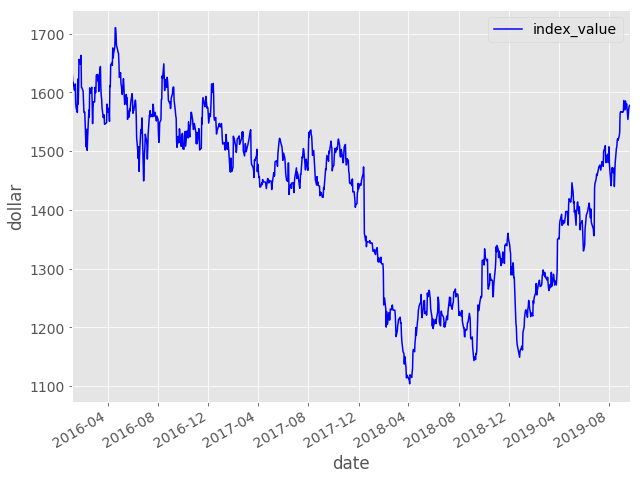

In [0]:
rcParams['figure.figsize'] = 10, 8 

ax = df.plot(x='trade_date', y='index_value', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("dollar")

In fact, some data is missing from the chart. The date is missing because the stock market does not work during the holiday, so some data is  not generated.

**The data set is divided into training set, verification set and test set.**

Size of training set, verification set, test set

In [0]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

num_train = 565
num_cv = 187
num_test = 187


**Cut the data set, leaving only the date and Index value**

In [0]:
train = df[:num_train][['trade_date', 'index_value']]
cv = df[num_train:num_train+num_cv][['trade_date', 'index_value']]
train_cv = df[:num_train+num_cv][['trade_date', 'index_value']]
test = df[num_train+num_cv:][['trade_date', 'index_value']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (565, 2)
cv.shape = (187, 2)
train_cv.shape = (752, 2)
test.shape = (187, 2)


**The training set**

In [0]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['index_value']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

scaler.mean_ = [1492.82079646]
scaler.var_ = [11724.15742184]
x_train_scaled.shape = (556, 9, 1)
y_train_scaled.shape = (556, 1)


**The validation set**

In [0]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['index_value']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (187, 9, 1)
y_cv.shape = (187, 1)
len(mu_cv_list) = 187
len(std_cv_list) = 187


**Training and verification**

In [0]:

scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['index_value']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['index_value]).reshape(-1,1), N, num_train+num_cv)
# print("x_test_scaled.shape = " + str(x_test_scaled.shape))
# print("y_test.shape = " + str(y_test.shape))
# print("len(mu_test_list) = " + str(len(mu_test_list)))
# print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [1430.28726064]
scaler_final.var_ = [21458.11484516]


***Long Short-Term Memory***

LSTM algorithm（LSTM） is widely used in sequence prediction. It proved to be an effective method. LSTM can store important past information and ignore unimportant information.
LSTM is divided into three stages: forget, select memory and output. It is mainly responsible for solving the problems of gradient disappearance and gradient explosion during long sequence training.


![替代文字](https://miro.medium.com/max/542/1*ULozye1lfd-dS9RSwndZdw.png)

**Set up the network**

In [0]:
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

model.summary()

Epoch 1/1
 - 46s - loss: 0.1154
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_219 (LSTM)              (None, 9, 50)             10400     
_________________________________________________________________
dropout_219 (Dropout)        (None, 9, 50)             0         
_________________________________________________________________
lstm_220 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_220 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


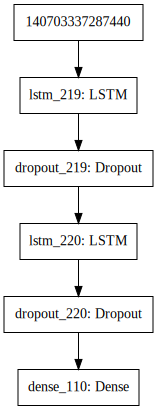

In [0]:
plot_model(model, to_file='model_lstm.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Root-mean-square deviation(RMSE) and mean absolute percentage error (MAPE) are the regression evaluation index. The value is smaller, the fitting effect is the better.

In [0]:

y_cv_pred_scaled = model.predict(x_cv_scaled)
y_cv_pred = (y_cv_pred_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("y_cv_pred.shape = " + str(y_cv_pred.shape))

rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, y_cv_pred))
print("RMSE = %0.3f" % rmse_bef_tuning)

mape_pct_bef_tuning = get_mape(y_cv, y_cv_pred)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

y_cv_pred.shape = (187, 1)
RMSE = 26.886
MAPE = 1.668%


**Prediction on the validation set**

Text(0,0.5,'USD')

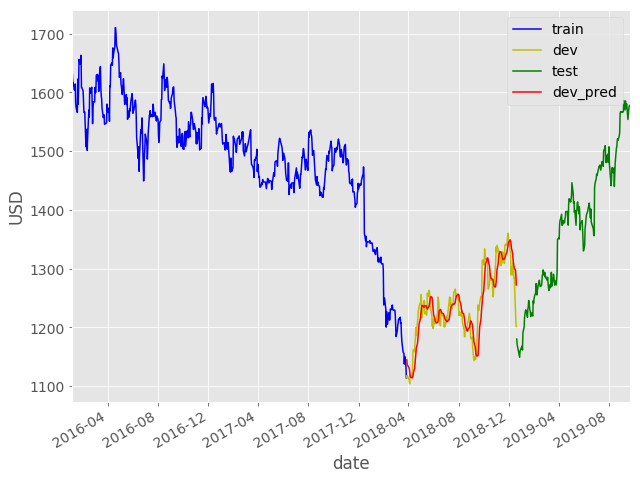

In [0]:
rcParams['figure.figsize'] = 10, 8 

pred_df = pd.DataFrame({'y_cv_pred': y_cv_pred.reshape(-1),   
                        'y_cv': y_cv.reshape(-1),
                        'date': cv['trade_date']})

ax = train.plot(x='trade_date', y='index_value', style='b-', grid=True)
ax = cv.plot(x='trade_date', y='index_value', style='y-', grid=True, ax=ax)
ax = test.plot(x='trade_date', y='index_value', style='g-', grid=True, ax=ax)
ax = pred_df.plot(x='date', y='y_cv_pred', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'dev_pred'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

The value of RMSE is relatively large, and the fitting effect is general.

**Tuning N (no. of days to use as features)**

In [0]:
param_label = 'N'
param_list = range(3, 40)

**Note：The code takes more than 15 minutes to run. Be patient.**

In [0]:


error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['index_value']).reshape(-1,1), param, num_train)
    
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer=optimizer,
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

Minutes taken = 52.4508416533


,N,mape_pct,rmse
0,3,1.350167,22.094897
1,4,1.533391,24.617856
2,5,1.551607,24.978044
3,6,1.689907,27.181102
4,7,1.549319,25.199639
5,8,1.742598,27.849476
6,9,1.695149,27.017142
7,10,1.591382,25.683862
8,11,1.518594,24.591412
9,12,1.604298,25.999650


**Error curve**

Text(0,0.5,'RMSE/MAPE(%)')

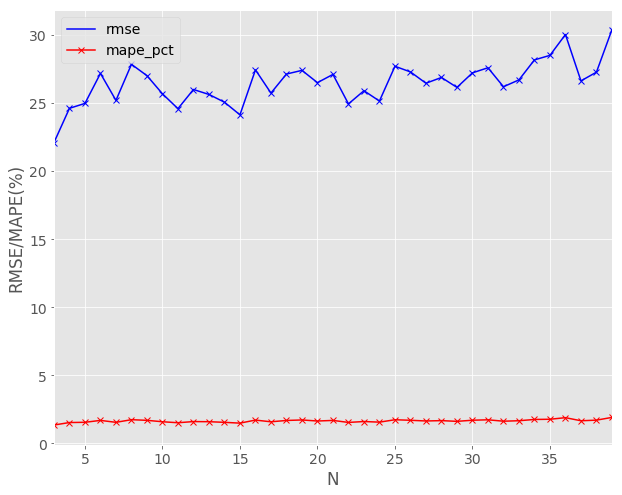

In [0]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [0]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]

print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 22.095
min MAPE = 1.350%
optimum N = 3


3 days is the best fitting time.

In [0]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]


x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)


x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['index_value']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()

for param in tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
      
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                              y_train_scaled,
                                              x_cv_scaled,
                                              y_cv,
                                              mu_cv_list,
                                              std_cv_list,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer=optimizer,
                                              epochs=param,
                                              batch_size=param2)
       
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

Minutes taken = 48.3733909011


,batch_size,epochs,mape_pct,rmse
0,8,1,1.326860,21.759872
1,16,1,1.279963,21.010512
2,32,1,1.166835,19.334779
3,64,1,1.165115,19.310341
4,128,1,1.154738,19.156724
5,8,10,1.223308,20.159808
6,16,10,1.268014,20.835111
7,32,10,1.310134,21.474766
8,64,10,1.345161,22.014037
9,128,10,1.337611,21.951463


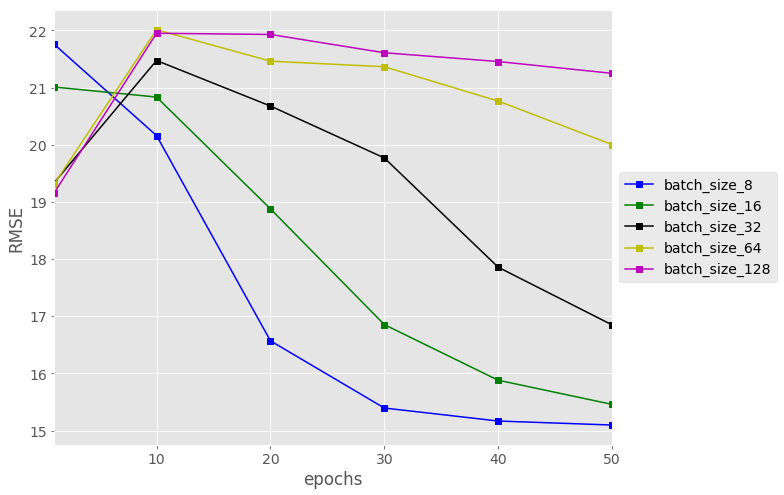

In [0]:
rcParams['figure.figsize'] = 10, 8 
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) 

In [0]:

temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]

print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 15.096
min MAPE = 0.848%
optimum epochs = 50
optimum batch_size = 8


***Arima model***


This is another stock forecasting model, compared with the lstm model.

ARIMA is a statistical method of time series prediction. The ARIMA model USES past values to predict future values. There are three important parameters in ARIMA:

P (the past value used to predict the next value)

Q (past forecasting error used to predict future value)

D (difference order)


![替代文字](https://www.machinelearningplus.com/wp-content/uploads/2019/02/Equation-2-min.png)

Arima function has been renamed many times. Its latest name is pyamid-arima.

In [29]:
pip install pyramid-arima

**Pyramid-arima program was not successfully installed, so the following code cannot run. I opened another Ipnp file to run, and as a result, I put in the code screenshots and connections.**


***Pyramid-arima program***


[Image link](https://sm.ms/image/EeXqQJUKyHj39Du)

https://sm.ms/image/EeXqQJUKyHj39Du



[Github link](https://github.com/aharriechen/hello-world/blob/master/Arima.ipynb)

https://github.com/aharriechen/hello-world/blob/master/Arima.ipynb

(<a href="https://sm.ms/image/EeXqQJUKyHj39Du" target="_blank"><img src="https://i.loli.net/2019/09/28/EeXqQJUKyHj39Du.png" ></a>)

The ARIMA model USES past data to understand time series. It uses these values to capture growth trends in the series. Although the technique works well in the short term, in the long term it still falls far short of what it actually is. The fitting effect of LSTM is better.

**The following code does not work and will report an error**. But I still not deleted them.I don't run this code.


This indicates no data loss.

In [0]:
len(df)
df.isna().any()

This is the first difference.

In [0]:
from pyramid.arima import auto_arima


data = df.sort_index(ascending=True, axis=0)

 
diff_data = train.diff()
diff_data.dropna(inplace=True)
diff_data.plot()
plt.show()

df = pd.read_csv(stk_path, sep = ",")

df['Trade Date'] = pd.to_datetime(df['Trade Date'],format='%Y-%m-%d')

#df['date'] = pd.to_datetime(df["date"].dt.strftime('%Y-%m'))


df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df = df.set_index('trade_date')
df['index_value_diff'] = df['index_value']-df.shift()['index_value']
df['index_value_diff_log'] = np.log1p(df['index_value'])-np.log1p(df.shift()['index_value'])
df = df[['index_value', 'index_value_diff', 'index_value_diff_log']]
df = df.dropna()
train = df['2017-01-01':'2018-01-01']
test = df['2018-01-01':]
len(train), len(test)

In [1]:
pip install plotly

Autocorrelation function and partial autocorrelation function（acf and pacf）

In [0]:
plt = sm.graphics.tsa.plot_acf(train['index_value_diff'], lags=40)
plt.show()


plt = sm.graphics.tsa.plot_pacf(train['index_value_diff'], lags=40)
plt.show()

In [0]:
res = sm.tsa.arma_order_select_ic(train['index_value_diff'], ic='aic', trend='nc')
res

In [0]:
from statsmodels.tsa.arima_model import ARIMA

arima_3_1_0 = ARIMA(train['index_value_diff'].as_matrix(), order=(3, 1, 0)).fit(dist=False)
arima_3_1_0.params

In [0]:
ts = train['index_value_diff'].as_matrix()
predictions = np.empty((0), dtype=np.float32)
n_pre = 100
for i in tqdm(range(n_pre)):
    arima_3_1_0 = ARIMA(ts, order=(3, 1, 0)).fit(dist=False)
    predict = arima_3_1_0.forecast()[0]
    predictions = np.hstack([predictions, predict])
    ts = np.hstack([ts, predict])

In [0]:
nans = np.zeros(len(train))
nans[:] = np.nan
orgs = pd.concat([train['index_value_diff'], test[:n_pre]['index_value_diff']])
orgs = pd.DataFrame({
    'Date': orgs.index,
    'Original': orgs.as_matrix(),
    'Prediction': np.hstack([nans, predictions])
})
orgs = orgs.set_index('Date')
orgs.plot(color=['blue', 'red'])
plt.show()

**Evaluation**


This paper introduces two timing models, ARIMA and LSTM. They have their own advantages.ARIMA(Auto Regressive Integrated Moving Average Model) can predict non-stationary sequences. The premise is that ARIMA can obtain stationary sequences by difference. ARIMA strengthens the role of recent observations on the predicted value, and gives different weights to the observed value at different times, thus increasing the weight of recent observations, so that the predicted value can quickly reflect the actual changes in the market. ARIMA is a commonly used time series forecasting model, but it is usually used for short-term forecasting. When it is applied to long-term forecasting, it can produces large errors. ARIMA  model is rarely used to predict stock movements. LSTM is more applied in the financial field. Because LSTM can store information from the past, it can simulate trends very well. The simulated curve in this article is better than ARIMA.



In fact, I think there is something wrong with the algorithm design of LSTM. It has three problems. First, the model has the possibility of garbage In garbage out. Third, it is based on past data to predict the future. Yet what has affected share prices in the past is likely to be different from what will happen in the future.



To test this model, I used the 7 stocks selected by the LSTM model to experiment on the simulation board for several weeks.



Result: losses cannot cover profits.



Obviously, this model cannot be applied to daily investment transactions.



Note: the blue represents losses and red represents profits.


![替代文字](https://i.postimg.cc/N0znmjXZ/IMG-2426.png)


https://postimg.cc/67CzNwYh/ffe4ede4

In my opinion, deep learning is an induction method based on historical data for fitting. If deep learning is used for stock prediction, it is expected to lose money in the long term, because the market is changing and the rules are changing,  the result may not be satisfactory.

For the LSTM model, the prediction data it USES is not the previous training data rather than  the verification data, which is equivalent to self-prediction, and the reliability of the result decrases. I hope this problem will be solved in the future.

LSTM can adjust various parameters in the model. It can also change the number of LSTM layers, add discarded values or increase the number of subgenerations. 

It should be noted that the successful installation of the module pyramid.arima is an important factor affecting the operation of the arima model. 'Pip install pyramidal-arima 'can run successfully in theory, in fact, sometimes it will not run successfully. Therefore, I've created a new environment to run it in.

**Conclusion**

The ARIAMA model and the LSTM model have many advantages. However, there are still many limitations.

One should not be fooled by articles that forecast curves completely overlap with real stock prices. That's just a simple average technique to replicate. In fact, it doesn't work.

Forecasting stock prices is an extremely difficult task. I don't think any stock forecasting model should be relied on blindly. Of course, models may correctly predict stock price movements in most cases.



**References**

https://www.jianshu.com/p/c019426e041d

https://github.com/fastai/fastai

https://36kr.com/p/5126349

https://xbuba.com/questions/47401526

https://blog.csdn.net/qq_32417287/article/details/79944597

https://blog.csdn.net/qq_40707407/article/details/81938941
